# **PID Controller Testing**
This notebook tests possible PID controller implementations that could be used in the boat simulator. Ran into issues due to earlier implementation that may not be consistent with Electrical Team planning. 

Old Ray Controller: https://github.com/UBCSailbot/raye-boat-controller/blob/master/python/tack_controller.py
\
Calculations based on: https://core.ac.uk/download/pdf/79618904.pdf

In [4]:
%pip install matplotlib simple_pid control

import matplotlib.pyplot as plt
import control as ctrl
import math

# from boat_simulator.nodes.low_level_control.control import VanilaPID

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## PID Implementation 
This class includes instances for VanilaPID, RudderPID and RobotPID. Additional Classes may be created by instantiating
a new error function that implements VanilaPID. This class represents the foundational PID class we created using the basic code architecture. The angle error calculation for the RudderPID is based on this post for calculating the signed delta angle: 
https://stackoverflow.com/questions/1878907/how-can-i-find-the-smallest-difference-between-two-angles-around-a-point/2007279#2007279


In [5]:
"""Low level control logic for actuating the rudder and the sail."""

from abc import ABC, abstractmethod
from math import atan2, cos, sin
from typing import Any, List

from boat_simulator.common.types import Scalar
from boat_simulator.common.utils import bound_to_180


class PID(ABC):
    """Abstract class for a PID controller.

    Attributes:
        `kp` (Scalar): The proportional component tuning constant.
        `ki` (Scalar): The integral component tuning constant.
        `kd` (Scalar): The derivative component tuning constant.
        `time_period` (Scalar): Constant time period between error samples.
        `buf_size` (int): The max number of error samples to store for integral component.
        `error_timeseries` (List[Scalar]): Timeseries of error values computed over time.
        `last_error` (float): The previous error calculated
        `integral_sum` (int): The running total of integral sum

    """

    def __init__(
        self,
        kp: Scalar,
        ki: Scalar,
        kd: Scalar,
        time_period: Scalar,
        buf_size: int,
        sum_threshold: Scalar,
    ):
        """Initializes the class attributes. Note that this class cannot be directly instantiated.

        Args:
            `kp` (Scalar): The proportional component tuning constant.
            `ki` (Scalar): The integral component tuning constant.
            `kd` (Scalar): The derivative component tuning constant.
            `time_period` (Scalar): Time period between error samples.
            `buf_size` (int): The max number of error samples to store for integral component.
            `last_error` (float): The error calculated in the previous iteration
            `integral_sum` (int): The running total of integral sum from integral response
        """
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.buf_size = buf_size
        self.time_period = time_period
        self.error_timeseries: List[Scalar] = list()
        self.integral_sum: Scalar = 0
        self.sum_threshold = sum_threshold

    def step(self, current: Any, target: Any) -> Scalar:
        """Computes the correction factor.

        Args:
            `current` (Any): Current state of the system.
            `target` (Any): Target state of the system.

        Returns:
            Scalar: Correction factor.
        """

        error = self._compute_error(current, target)
        feedback = (
            self._compute_derivative_response(error)
            + self._compute_integral_response(error)
            + self._compute_proportional_response(error)
        )
        self.append_error(error)
        return feedback

    def reset(self, is_latest_error_kept: bool = False):
        """Empties the error timeseries of the PID controller, effectively starting a new
        control iteration.

        Args:
            is_latest_error_kept (bool, optional): True if the latest error is kept in the error
                timeseries to avoid starting from scratch if the target remains the same. False
                if the timeseries should be completely emptied. Defaults to False.
        """
        self.integral_sum = 0
        self.error_timeseries.clear

    def append_error(self, error: Scalar) -> None:
        """Appends the latest error to the error timeseries attribute. If the timeseries is at
        the maximum buffer size, the least recently computed error is evicted from the timeseries
        and the new one is appended.

        Args:
            `error` (Scalar): The latest error.
        """
        if len(self.error_timeseries) < self.buf_size:
            self.error_timeseries.append(error)
        else:
            self.integral_sum -= self.error_timeseries[0] * self.time_period
            self.error_timeseries.pop(0)
            self.error_timeseries.append(error)

    @abstractmethod
    def _compute_error(self, current: Any, target: Any) -> Scalar:
        """Computes the currently observed error.

        Args:
            current (Any): Current state of the system.
            target (Any): Target state of the system.

        Returns:
            Scalar: Current error between the current and target states.
        """
        pass

    @abstractmethod
    def _compute_proportional_response(self, error: Any) -> Scalar:
        """
        Args:
            error (Any): Current calculated error for present iteration

        Returns:
            Scalar: The proportional component of the correction factor.
        """
        pass

    @abstractmethod
    def _compute_integral_response(self, error: Any) -> Scalar:
        """
        Args:
            error (Any): Current calculated error for present iteration
            integral_sum (int): The running total of integral sum from integral response

        Returns:
            Scalar: The integral component of the correction factor.
        """
        pass

    @abstractmethod
    def _compute_derivative_response(self, error: Any) -> Scalar:
        """
         Args:
            error (Any): Current calculated error for present iteration
            last_error (float): The error calculated in the previous iteration

        Returns:
            Scalar: The derivative component of the correction factor.
        """
        pass

    @property
    def last_error(self):
        return self.error_timeseries[-1]


class VanilaPID(PID):
    """General Class for the PID controller.

    Extends: PID
    """

    def __init__(
        self,
        kp: Scalar,
        ki: Scalar,
        kd: Scalar,
        time_period: Scalar,
        buf_size: int,
        sum_threshold: Scalar,
    ):
        """Initializes the class attributes.

        Args:
            `kp` (Scalar): The proportional component tuning constant.
            `ki` (Scalar): The integral component tuning constant.
            `kd` (Scalar): The derivative component tuning constant.
            `time_period` (Scalar): Time period between error samples.
            `buf_size` (int): The max number of error samples to store for integral component.
            `last_error` (float): The error calculated in the previous iteration
            `integral_sum` (Scalar): The running total of integral sum from integral response
        """
        super().__init__(
            kp,
            ki,
            kd,
            time_period,
            buf_size,
            sum_threshold,
        )

    def _compute_proportional_response(self, error: Scalar) -> Scalar:
        return self.kp * error

    def _compute_integral_response(self, error: Scalar) -> Scalar:
        current_sum = self.integral_sum + (self.time_period * error)

        if abs(current_sum) < self.sum_threshold:
            self.integral_sum = current_sum
        else:
            self.integral_sum = self.sum_threshold
        return self.ki * self.integral_sum

    def _compute_derivative_response(self, error: Scalar) -> Scalar:
        if not self.error_timeseries:
            return 0
        else:
            derivative_response = (error - self.last_error) / self.time_period
            return self.kd * derivative_response


class RudderPID(VanilaPID):
    """Individual Class for the rudder PID controller.

    Extends: VanilaPID
    """

    def _compute_error(self, current: Scalar, target: Scalar) -> Scalar:
        error = atan2(sin(target - current), cos(target - current))
        current_bound = bound_to_180(current)
        target_bound = bound_to_180(target)
        if current_bound == target_bound:
            error = 0
        return error


class RobotPID(VanilaPID):
    """Individual Class for the Model Robot Arm PID controller.

    Extends: VanilaPID
    """

    def _compute_error(self, current, target):
        return target - current

## Graph Testing of PID Implementation
Uses transfer function: 
$$([k_d, k_p, k_i], [1,0])$$
which relates to the function:
$$f(s) = \frac{k_ds^2 + k_ps + k_i}{s}$$
$$L^{-1}\{f(s)\} = PID(t)$$
Use the inverse laplace transform:
$$L^{-1}\{\frac{1}{s^2 + 2s + 1}\} = e^{-t}t$$
where $t$ is the feedback outputed from our PID controller. The final function output correlates to the new 
position of the object after the plant process, which we feed back in to calculate the new error from the setpoint. The issues came with determining how our plant process utilizing this feedback to adjust the current model closer to the target value. 


In [6]:
"""Robot Arm Test implementation for PID Controller"""

from abc import ABC, abstractmethod
from math import exp
from typing import Any, List


from boat_simulator.common.types import Scalar
from boat_simulator.common.utils import bound_to_180

GRAVITY = 9.8


class Plant:
    # Private class member defaults

    __target_position: Scalar = 0.0
    __current_position: Scalar = 0.0
    __time_period: Scalar = 0.0
    __position_log: List[Scalar] = list()
    __time_log: List[Scalar] = list()

    def __init__(
        self,
        target_position: Scalar,
        current_position: Scalar,
        time_period: Scalar,
    ):
        self.__target_position = target_position
        self.__current_position = current_position
        self.__time_period = time_period
        self.__position_log = []
        self.__time_log = []

    def run(
        self,
        count: int,
        controller: RobotPID,
    ) -> Scalar:
        running_time = 0
        self.__position_log.append(0)
        self.__time_log.append(0)
        prev_position = self.__current_position
        for _ in range(count):
            feedback = controller.step(prev_position, self.__target_position)

            position = math.exp(-feedback) * feedback

            self.__position_log.append(position)
            self.__time_log.append(running_time)

            prev_position = position
            running_time += self.__time_period
        return self.__time_log, self.__position_log

# Graph Testing using RobotPID
Graphs the output using tuning values. Our issue was finding the correct tuning values so that the output matched the expected PID controller graphs. This was the simplest model using error of $y_2 - y_1$. The graph did display damping oscillating behaviour as it settled at a constant value. The issue was our target was 0.1, whereas the setting position seems to finish at just over 0.08. Again, these tuning values were completely arbitrary through calculated guesses.

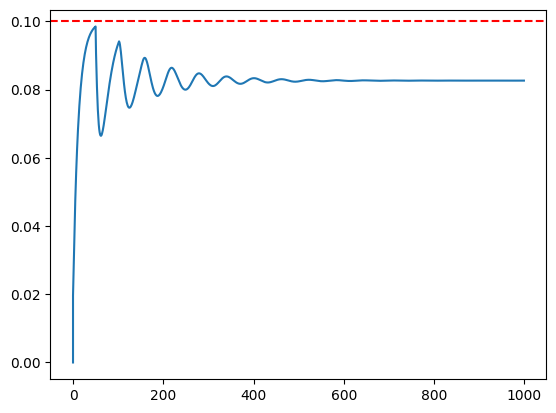

In [7]:
from matplotlib import pyplot as plt

dt = 1

pid = RobotPID(kp=0.1, ki=0.1, kd=0.01, time_period=dt, buf_size=50, sum_threshold=100)
robot = Plant(target_position=0.1, current_position=0, time_period=dt)
x, y = robot.run(controller=pid, count=1000)

plt.plot(x, y)
plt.axhline(y=0.1, color="r", linestyle="--")
# plt.plot(x, robot.forces)

# function to show the plot
plt.show()

# Generated controller using TransferFunction from Python "control" library
Using the control library: https://pypi.org/project/control/, this was a generated code to test an known plant process (feedback function) and graphing the resulting output. The output was somewhat we thought the expected feedback graph should resemble. 

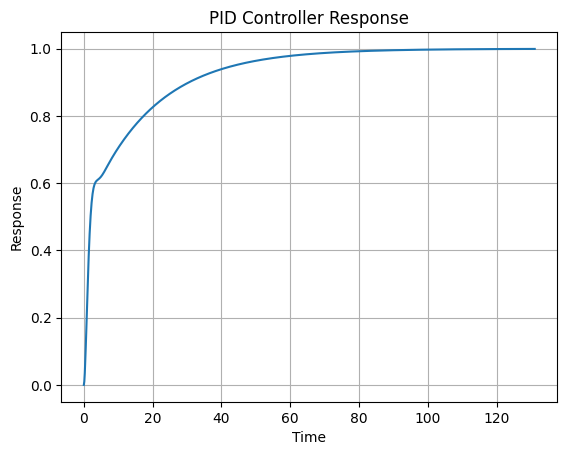

In [8]:
# Define the system
system = ctrl.TransferFunction([1], [1, 2, 1])

# Define PID controller parameters
kp = 1.0
ki = 0.1
kd = 0.01

# Create a PID controller
pid_controller = ctrl.TransferFunction([kd, kp, ki], [1, 0])

# Connect the PID controller to the system
closed_loop_system = ctrl.feedback(system * pid_controller)

# Time vector
time, response = ctrl.step_response(closed_loop_system)

# Plot the response


plt.plot(time, response)
plt.xlabel("Time")
plt.ylabel("Response")
plt.title("PID Controller Response")
plt.grid(True)
plt.show()

# Notebook Testing of RobotArm Implementation
This was the first implementation that we tested using the original assumptions. The run functions calls a certain num_steps which acts as our iterative time step. This hopefully minimizes our error and we move toward the target value.

In [9]:
class RobotArm:
    def __init__(self, pid, mass, start_position, target_position, dt):
        self.pid = pid
        self.mass = mass
        self.start_position = start_position
        self.target_position = target_position
        self.dt = dt

        self.times = list()
        self.positions = list()
        self.forces = list()

    def run(self, num_steps, start_upward_force):
        # Fill in values for time 0
        self.times.append(0)
        self.positions.append(self.start_position)
        self.forces.append(0)

        # Define starting kinematics
        prev_acceleration = 0
        prev_velocity = 0
        prev_position = self.start_position

        force = start_upward_force

        for i in range(num_steps):
            current_time = (i + 1) * self.dt

            # Step 1: Get the feedback from PID and store the new force (but do not update yet)
            feedback = self.pid.step(prev_position, self.target_position)

            # Step 2: Compute the new kinematics with previous info, but do not update yet
            acceleration = self.__compute_acceleration(force)
            velocity = self.__compute_velocity(prev_velocity, prev_acceleration)
            position = self.__compute_position(prev_position, prev_velocity, prev_acceleration)

            # Step 3: Update the force
            new_force = force - feedback
            if new_force >= 0:
                force = new_force
            else:
                force = 0

            # Step 4: Add all new data to arrays
            self.times.append(current_time)
            self.positions.append(position)
            self.forces.append(force)

            # Step 5: Update the previous kinematic values to be the newly computed ones
            prev_position = position
            prev_velocity = velocity
            prev_acceleration = acceleration

        return self.times, self.positions

    def __compute_acceleration(self, prev_upward_force):
        downward_force = 9.81 * self.mass
        return (downward_force - prev_upward_force) / self.mass

    def __compute_velocity(self, prev_velocity, prev_acceleration):
        return prev_velocity + (prev_acceleration * self.dt)

    def __compute_position(self, prev_position, prev_velocity, prev_acceleration):
        accel_comp = (prev_acceleration * (self.dt**2)) / 2
        return prev_position + (prev_velocity * self.dt) + accel_comp

# OSCILLATING GRAPH CREATED!
Was able to create an oscillating graph again using arbitrary, educated guessing kp, ki, and kd values. 

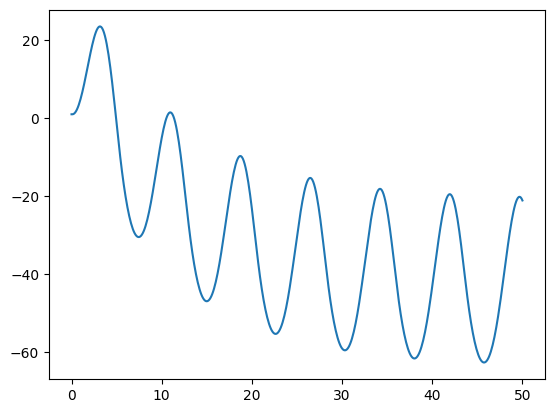

In [10]:
from matplotlib import pyplot as plt

dt = 0.1

pid = RobotPID(kp=0.01, ki=0, kd=0.1, time_period=dt, buf_size=50, sum_threshold=10)
robot = RobotArm(
    pid=pid,
    mass=1,
    start_position=1,
    target_position=0,
    dt=dt,
)

breakpoint()

x, y = robot.run(num_steps=500, start_upward_force=0)

plt.plot(x, y)
# plt.plot(x, robot.forces)

# function to show the plot
plt.show()

# Unknown Testing
This implementation was in our original notebook as well, but was one of the first iterations of the controller. Seems to have certain errors, but could be useful to look back in the future and see what worked and what didn't.

In [ ]:
"""Robot Arm Test implementation for PID Controller"""

from abc import ABC, abstractmethod
from typing import Any, List


from boat_simulator.common.types import Scalar
from boat_simulator.common.utils import bound_to_180

GRAVITY = 9.8


class RobotArm:
    # Private class member defaults
    __mass: float = 0.0
    __target_position: Scalar = 0.0
    __current_position: Scalar = 0.0
    __time_period: Scalar = 0.0
    __position_log: List[Scalar] = list()
    __time_log: List[Scalar] = list()

    def __init__(
        self,
        mass: float,
        target_position: Scalar,
        current_position: Scalar,
        time_period: Scalar,
        position_log: list,
        time_log: list,
    ):
        self.__mass = mass
        self.__target_position = target_position
        self.__current_position = current_position
        self.__time_period = time_period
        self.__position_log = position_log
        self.__time_log = time_log

    def run(
        self,
        count: int,
        controller: RobotPID,
        force: float,
        velocity: float,
    ) -> Scalar:
        weight = self.__mass * GRAVITY
        running_time = 0
        prev_position = self.__current_position
        prev_velocity = 0
        prev_acceleration = 0
        for _ in range(count):
            feedback = controller.step(prev_position, self.target_position)

            acceleration = (weight - force) / self.__mass

            velocity = prev_velocity + (prev_acceleration * self.__time_period)

            accel_comp = (prev_acceleration * (self.__time_period**2)) / 2

            position = prev_position + (prev_velocity * self.__time_period) + accel_comp

            self.__position_log.append(position)
            self.__time_log.append(running_time)

            running_time += self.__time_period
            force += feedback

            self.__current_position = position
            prev_position = position
            prev_velocity = velocity
            prev_acceleration = acceleration

# Current Progress

With the current state of the PID controller, we met with the Electrical team to discuss whether they had a Transfer Function or Controller implementation in mind. They seemed to have done a lot of work in MatLab already, which would require large amounts of work to transfer into Python. In the end, we decided for the simulator, it would be easier to use Raye's controller code, which was more consistent and tested to give reliable results. The hope with the PID is to come back to this testing in the future for Polaris' actually controller as we still want to use a PID controller for the most optimal error optimization. This notebook documented all of our work and testing so far during the term and will hopefully be a resource in the future. Other resources to consult:

https://www.ctrlaltftc.com/the-pid-controller/the-proportional-term
\
https://electronics.stackexchange.com/questions/629032/pid-controller-implementation-in-python
